In [93]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [94]:
import numpy as np
import pandas as pd

In [95]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [96]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [97]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [98]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [99]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [100]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
conn = engine.connect()

In [101]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [102]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
perc_data1 = pd.read_sql("SELECT * FROM Measurement WHERE date BETWEEN datetime('2017-08-23', '-1 years') AND datetime('2017-08-23')", conn)
perc_data1["date"]

0       2016-08-24
1       2016-08-25
2       2016-08-26
3       2016-08-27
4       2016-08-28
5       2016-08-29
6       2016-08-30
7       2016-08-31
8       2016-09-01
9       2016-09-02
10      2016-09-03
11      2016-09-04
12      2016-09-05
13      2016-09-06
14      2016-09-07
15      2016-09-08
16      2016-09-09
17      2016-09-10
18      2016-09-11
19      2016-09-12
20      2016-09-13
21      2016-09-14
22      2016-09-15
23      2016-09-16
24      2016-09-17
25      2016-09-18
26      2016-09-19
27      2016-09-20
28      2016-09-21
29      2016-09-22
           ...    
2193    2017-07-24
2194    2017-07-25
2195    2017-07-26
2196    2017-07-27
2197    2017-07-28
2198    2017-07-29
2199    2017-07-30
2200    2017-07-31
2201    2017-08-01
2202    2017-08-02
2203    2017-08-03
2204    2017-08-05
2205    2017-08-06
2206    2017-08-07
2207    2017-08-08
2208    2017-08-09
2209    2017-08-10
2210    2017-08-11
2211    2017-08-12
2212    2017-08-13
2213    2017-08-14
2214    2017

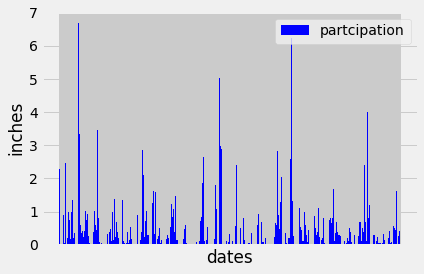

In [103]:
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(perc_data1["date"], perc_data1["prcp"], color="b", label="partcipation", align="center")

plt.xlabel("dates")
plt.ylabel("inches")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend()
plt.show()

In [104]:
# Use Pandas to calcualte the summary statistics for the precipitation data
perc_data1['prcp'].to_frame().describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [105]:
# Design a query to show how many stations are available in this dataset?
session_data = session.query(Measurement).group_by(Measurement.station).count()
session_data

9

In [106]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session_data2 = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by('count DESC').all()
session_data2

C:\Users\18045\AppData\Local\Continuum\anaconda3\lib\site-packages\sqlalchemy\sql\compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [107]:
# Using the station id from the previous query
station_id = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
station_id

# Calculate the lowest, highest temperature recorded, and average temperature most active station?

temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==station_id).all()


[(54.0, 85.0, 71.66378066378067)]

In [123]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 

station_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==station_id).\
                                order_by(Measurement.date.desc()).all()
station_obs_df = pd.DataFrame(station_obs)
station_obs_df.head()


,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


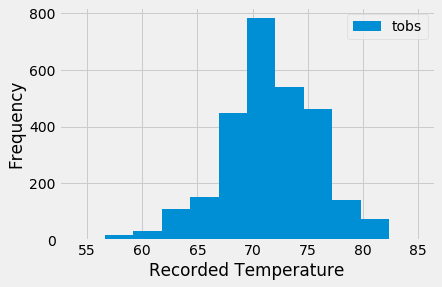

In [109]:
#plot the results as a histogram

plt.hist(station_obs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.show()

In [110]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-24-08', '2017-23-08'))

[(58.0, 74.14387974230493, 87.0)]


In [111]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2016-24-08', '2017-23-08'))

[(58.0, 74.14387974230493, 87.0)]


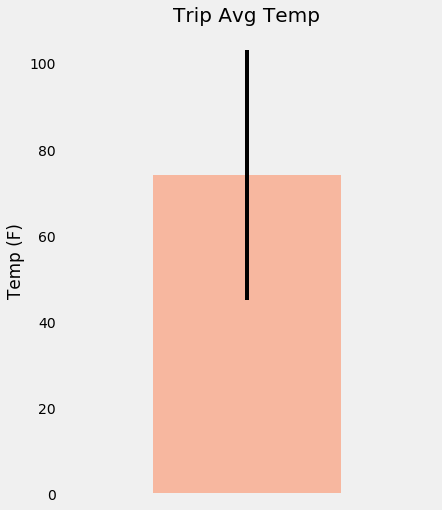

In [112]:
# Plot the results from your previous query as a bar chart. 
trp_rslt = calc_temps('2016-24-08', '2017-23-08')
trip_df = pd.DataFrame(trp_rslt, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_tmp = trip_df['Avg Temp']
min_max_tmp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_tmp.plot(kind='bar', yerr=min_max_tmp, figsize=(6,8), alpha=0.5, color='coral')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.xticks([])
plt.grid()
plt.show()

# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [113]:
trp_rslt = calc_temps('2016-24-08', '2017-23-08')
trp_rslt
trip_df = pd.DataFrame(trp_rslt, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
trip_df

,Min Temp,Avg Temp,Max Temp
0,58.0,74.14388,87.0


In [133]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

trp_start = '2016-08-24'
trp_end = '2017-08-23'

station2 = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

prec_amount = session.query(*station2).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trp_start).\
    filter(Measurement.date >= trp_end).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()

print (prec_amount)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.45), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.08), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


## Optional Challenge Assignment

In [115]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [116]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [117]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


<IPython.core.display.Javascript object>


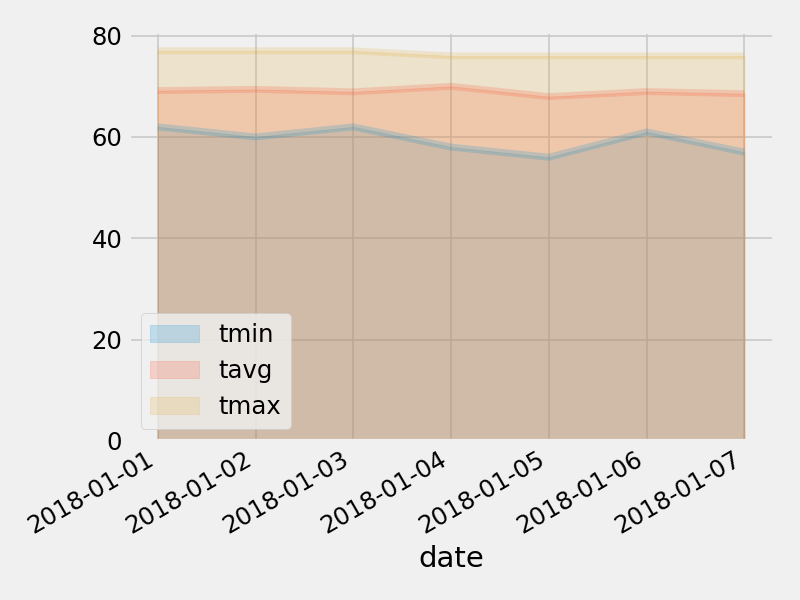

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
